In [4]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import math


In [7]:
def make_signal(w,theta,n):
    """
    Assumes normalized amplitude
    """
    t = np.arange(n)
    signal = np.exp(1j*(w*t + theta))
    return signal

def make_noise(sigma2,n):
    noise_scaling = np.sqrt(sigma2/2)
    # noise is complex valued
    noise  = noise_scaling*np.random.randn(n) + 1j*noise_scaling*np.random.randn(n)
    return noise

def make_noisy_signal(w,theta,SNRdb,n):
    sigma2 = get_sigma2_from_snrdb(SNRdb)
    signal = make_signal(w,theta,n)
    noise  = make_noise(sigma2,n)
    return signal + noise

# N = divisor of w0
# m = num samples
def make_batch_noisy(batch_size, SNRdb, N, m, binary=False):
    signals, freqs = [], []
    for i in range(batch_size):
        freq = np.random.randint(0, N)
        w = (2 * np.pi * freq / N) % (2 * np.pi)
        sig = make_noisy_signal(w, 0, SNRdb, m)
        signals.append(sig)
        freqs.append(freq)
    if binary:
        return signals, make_binary(freqs, N), one_hot(N, batch_size, freqs)
    return signals, one_hot(N, batch_size, freqs)

def make_batch_singleton(batch_size, SNRdb, N, m):
    signals, freqs = [], []
    sigma2 = get_sigma2_from_snrdb(SNRdB)
    for i in range(batch_size):
        val = np.random.poisson(0.79)
        if val == 0:
            signals.append(make_noise(0, m))
            freqs.append([1, 0, 0])
        if val == 1:
            signals.append(make_noisy_signal(2 * np.pi * np.random.randint(0, N) / N, 0, SNRdB, m))
            freqs.append([0, 1, 0])
        if val >= 2:
            signal = make_signal(2 * np.pi * np.random.randint(0, N) / N, 0, m)
            for i in range(val - 1):
                signal += make_signal(2 * np.pi * np.random.randint(0, N) / N, 0, m)
            signals.append(signal + make_noise(sigma2, m))
            freqs.append([0, 0, 1])
    return signals, freqs

def get_sigma2_from_snrdb(SNR_db):
    return 10**(-SNR_db/10)

def kay_weights(N):
    scaling = (3.0/2)*N/(N**2 - 1)
    
    w = [1 - ((i - (N/2 - 1))/(N/2))**2 for i in range(N-1)]
    
    return scaling*np.array(w)

def kays_method(my_signal):
    N = len(my_signal)
    w = kay_weights(N)
    
    angle_diff = np.angle(np.conj(my_signal[0:-1])*my_signal[1:])
    need_to_shift = np.any(angle_diff < -np.pi/2)
    if need_to_shift:    
        neg_idx = angle_diff < 0
        angle_diff[neg_idx] += np.pi*2
    
    return w.dot(angle_diff)

def kays_singleton_accuracy(test_signals, test_freqs, N):
    diffs = [s - make_signal(kays_method(s), 0, N) for s in test_signals]
    thresh, single_acc, other_acc, best_thresh = 0.0, 0, 0, 0
    best = 0
    for i in range(150):
        vals = [(sum(np.absolute(s)) / N) < thresh for s in diffs]
        corr = [1 for i in range(len(test_freqs)) if (test_freqs[i] == [0, 1, 0] and vals[i] == 1) or ((test_freqs[i] != [0, 1, 0] and vals[i] == 0))]
        corr = sum(corr)
        #single = sum([vals[d] for d in range(len(vals)) if test_freqs[d] == [0, 1, 0]]) / len([vals[d] for d in range(len(vals)) if test_freqs[d] == [0, 1, 0]])
        #other = sum([not vals[d] for d in range(len(vals)) if test_freqs[d] != [0, 1, 0]]) / len([vals[d] for d in range(len(vals)) if test_freqs[d] != [0, 1, 0]])        
        #if single*2 + other > single_acc*2 + other_acc and single > 0.2 and other > 0.2:
        #    single_acc = single
        #    other_acc = other
        #    best_thresh = thresh
        if corr > best:
            best = corr
            best_thresh = thresh
        thresh += 0.05
    print('thresh: ', best_thresh)
    return best / len(test_signals)

def test_kays(signals, freqs, N):
    count = 0
    for sig, freq in zip(signals, freqs):
        res = kays_method(sig)
        res = round(res * N / (2 * np.pi))
        if np.argmax(freq) == res:
            count += 1
    return count / len(signals)

def test_mle(signals, freqs, N, m):
    count = 0
    for sig, freq in zip(signals, freqs):
        cleans = [make_signal(np.pi * 2 * w / N, 0, m) for w in range(N)]
        dots = [np.absolute(np.vdot(sig, clean)) for clean in cleans]
        if np.argmax(dots) == np.argmax(freq):
            count += 1
    return count / len(signals)
    
def make_binary(freqs, N):
    w = math.ceil(np.log2(N))
    return [[int(a) for a in list(np.binary_repr(f, width=w))] for f in freqs] 

def binary_to_int(binary_string):
    return tf.reduce_sum(
    tf.cast(tf.reverse(tensor=binary_string, axis=[0]), dtype=tf.int64)
    * 2 ** tf.range(tf.cast(tf.size(binary_string), dtype=tf.int64)))
    '''y = 0
    for i,j in enumerate(x):
        y += j<<i
    return y'''

def hamming(pred, act):
    return np.count_nonzero(pred != act)

def one_hot(N, batch_size, freqs):
    freqs_one_hot = np.zeros((batch_size, N))
    freqs_one_hot[np.arange(batch_size), freqs] = 1
    return freqs_one_hot
    

Training Finished for snr= 8
Testing Accuracy Neural: 1.0
thresh:  0.7000000000000001
Testing Accuracy Kay: 0.932
Training Finished for snr= 8
Testing Accuracy Neural: 0.804
thresh:  0.39999999999999997
Testing Accuracy Kay: 0.952
Training Finished for snr= 8
Testing Accuracy Neural: 1.0
thresh:  0.39999999999999997
Testing Accuracy Kay: 0.939
Training Finished for snr= 8
Testing Accuracy Neural: 0.999
thresh:  0.9000000000000002
Testing Accuracy Kay: 0.949
Training Finished for snr= 8
Testing Accuracy Neural: 1.0
thresh:  0.9500000000000003
Testing Accuracy Kay: 0.95
Training Finished for snr= 8
Testing Accuracy Neural: 1.0
thresh:  0.39999999999999997
Testing Accuracy Kay: 0.931
Training Finished for snr= 8
Testing Accuracy Neural: 1.0
thresh:  0.65
Testing Accuracy Kay: 0.941
Training Finished for snr= 8
Testing Accuracy Neural: 0.98
thresh:  0.8000000000000002
Testing Accuracy Kay: 0.936
Training Finished for snr= 8
Testing Accuracy Neural: 1.0
thresh:  0.39999999999999997
Testing 

thresh:  0.0
Testing Accuracy Kay: 0.652
Training Finished for snr= -6
Testing Accuracy Neural: 0.926
thresh:  0.0
Testing Accuracy Kay: 0.636
Training Finished for snr= -6
Testing Accuracy Neural: 0.826
thresh:  0.0
Testing Accuracy Kay: 0.611
Training Finished for snr= -6
Testing Accuracy Neural: 0.8
thresh:  0.0
Testing Accuracy Kay: 0.626
Training Finished for snr= -6
Testing Accuracy Neural: 0.483
thresh:  0.0
Testing Accuracy Kay: 0.66
Training Finished for snr= -6
Testing Accuracy Neural: 0.953
thresh:  0.0
Testing Accuracy Kay: 0.643


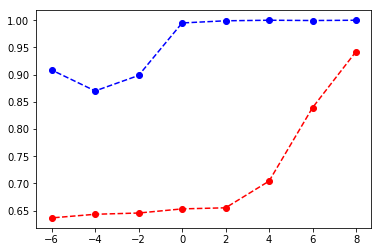

In [5]:
# seeing snr vs accuracy for singleton detection (kay vs nn)

nn_accs = []
kay_1s = []
kay_2s = []
snrs = [8, 6, 4, 2, 0, -2, -4, -6]

for SNRdB in snrs:
    
    trial_nn = []
    trial_kay = []
    for _ in range(10):

        N = 27000 #512
        #SNRdB = 0
        m = 300 #16

        # Parameters
        learning_rate = 0.005
        num_iter = 8000
        batch_size = 1000

        # Network Parameters
        num_classes = 3

        # tf Graph input
        X = tf.placeholder("float", [None, m, 2])
        Y = tf.placeholder("float", [None, num_classes])

        # Store layers weight & bias
        weights = {
            'h1': tf.Variable(tf.random_normal([5, 2, 2])), # filtersize, in channels, outchannels
            'out': tf.Variable(tf.random_normal([(m-4-2-2)*2, num_classes])),
            'h2': tf.Variable(tf.random_normal([3, 2, 2])),
            'h3': tf.Variable(tf.random_normal([3, 2, 2]))
        }
        biases = {
            'b1': tf.Variable(tf.random_normal([2])),
            'out': tf.Variable(tf.random_normal([num_classes])),
            'b2': tf.Variable(tf.random_normal([2])),
            'b3': tf.Variable(tf.random_normal([2]))
        }

        test_signals, test_freqs = make_batch_singleton(batch_size, SNRdB, N, m)
        test_signals_pair = np.zeros((batch_size, m, 2))
        test_signals_pair[:, :, 0] = np.real(test_signals)
        test_signals_pair[:, :, 1] = np.imag(test_signals)
        training_size = 500
        dict = {}
        for i in range(training_size):
            batch_x, batch_y = make_batch_singleton(batch_size, SNRdB, N, m)
            batch_x_pair = np.zeros((batch_size, m, 2))
            batch_x_pair[:, :, 0] = np.real(batch_x)
            batch_x_pair[:, :, 1] = np.imag(batch_x)
            dict[i] = (batch_x_pair, batch_y)

        def neural_net(x):
            layer_1 = tf.add(tf.nn.conv1d(x, weights['h1'], 1, 'VALID'), biases['b1'])
            hidden_1 = tf.nn.relu(layer_1)
            layer_2 = tf.add(tf.nn.conv1d(hidden_1, weights['h2'], 1, 'VALID'), biases['b2'])
            hidden_2 = tf.nn.relu(layer_2)
            layer_3 = tf.add(tf.nn.conv1d(hidden_2, weights['h3'], 1, 'VALID'), biases['b3'])
            hidden_3 = tf.nn.relu(layer_3)
            hidden_3 = tf.reshape(hidden_3, [batch_size, -1])
            out_layer = tf.matmul(hidden_3, weights['out']) + biases['out']
            return out_layer

        # Construct model
        logits = neural_net(X)
        prediction = tf.nn.softmax(logits)
        losses, accuracies = [], []

        # Define loss and optimizer
        loss_op = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(
            logits=logits, labels=Y))  
        '''+ 0.01*tf.nn.l2_loss(weights['h1']) + 0.01*tf.nn.l2_loss(weights['h2']) + 0.01*tf.nn.l2_loss(weights['out']) \
        + 0.01*tf.nn.l2_loss(biases['b1']) + 0.01*tf.nn.l2_loss(biases['b2']) + 0.01*tf.nn.l2_loss(biases['out']) '''
        optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
        train_op = optimizer.minimize(loss_op)

        # Evaluate model
        correct_pred = tf.equal(tf.argmax(prediction, 1), tf.argmax(Y, 1))
        accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))

        # Initialize the variables (i.e. assign their default value)
        init = tf.global_variables_initializer()

        # Start training
        with tf.Session() as sess:

            # Run the initializer
            sess.run(init)

            for step in range(1, num_iter + 1):
                batch_x_pair, batch_y = dict[step % training_size]

                # Run optimization op (backprop)
                sess.run(train_op, feed_dict={X: batch_x_pair, Y: batch_y})
                if step % 500 == 0:
                    # Calculate batch loss and accuracy
                    loss, acc, pred = sess.run([loss_op, accuracy, prediction], feed_dict={X: batch_x_pair,
                                                                         Y: batch_y})

                    #print("pred: ", [np.argmax(a) for a in pred[:8]])
                    #print("act:", [np.argmax(a) for a in batch_y[:8]])
                    accuracies.append(acc)
                    losses.append(loss)
                    #print("snr: ", SNRdB)
                    #print("Iter " + str(step) + ", Minibatch Loss= " + \
                    #      "{:.4f}".format(loss) + ", Training Accuracy= " + \
                    #      "{:.3f}".format(acc))
            print("Training Finished for snr=", SNRdB)

            nn_acc = sess.run(accuracy, feed_dict={X: test_signals_pair, Y: test_freqs})        
            print("Testing Accuracy Neural:", nn_acc)
            kay_acc = kays_singleton_accuracy(test_signals, test_freqs, m)
            print("Testing Accuracy Kay:", kay_acc)
            trial_nn.append(nn_acc)
            trial_kay.append(kay_acc)
    nn_accs.append(np.median(trial_nn))
    kay_1s.append(np.mean(trial_kay))
        
np.save('./data/singleton/snrs', snrs)
np.save('./data/singleton/nn_accs', nn_accs)
np.save('./data/singleton/kay_accs', kay_1s)
plt.plot(snrs, nn_accs, '--bo')
plt.plot(snrs, kay_1s, '--ro')
plt.show()

Training Finished for layers= 1
Testing Accuracy Neural: 0.902
Training Finished for layers= 1
Testing Accuracy Neural: 0.817
Training Finished for layers= 1
Testing Accuracy Neural: 0.887
Training Finished for layers= 1
Testing Accuracy Neural: 0.89
Training Finished for layers= 1
Testing Accuracy Neural: 0.817
Training Finished for layers= 1
Testing Accuracy Neural: 0.913
Training Finished for layers= 1
Testing Accuracy Neural: 0.877
Training Finished for layers= 1
Testing Accuracy Neural: 0.882
Training Finished for layers= 1
Testing Accuracy Neural: 0.566
Training Finished for layers= 1
Testing Accuracy Neural: 0.854
Training Finished for layers= 3
Testing Accuracy Neural: 0.913
Training Finished for layers= 3
Testing Accuracy Neural: 0.872
Training Finished for layers= 3
Testing Accuracy Neural: 0.468
Training Finished for layers= 3
Testing Accuracy Neural: 0.817
Training Finished for layers= 3
Testing Accuracy Neural: 0.816
Training Finished for layers= 3
Testing Accuracy Neural:

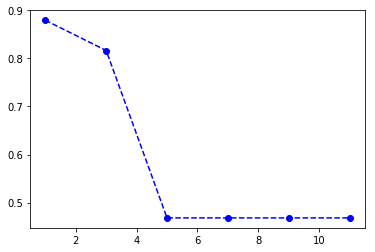

In [6]:
# seeing num layers vs accuracy 

nn_accs = []
layers = [1, 3, 5, 7, 9, 11]

N = 27000 
SNRdB = -8
m = 300 

learning_rate = 0.005
num_iter = 8000
batch_size = 1000

test_signals, test_freqs = make_batch_singleton(batch_size, SNRdB, N, m)
test_signals_pair = np.zeros((batch_size, m, 2))
test_signals_pair[:, :, 0] = np.real(test_signals)
test_signals_pair[:, :, 1] = np.imag(test_signals)
training_size = 500

dict = {}
for i in range(training_size):
    batch_x, batch_y = make_batch_singleton(batch_size, SNRdB, N, m)
    batch_x_pair = np.zeros((batch_size, m, 2))
    batch_x_pair[:, :, 0] = np.real(batch_x)
    batch_x_pair[:, :, 1] = np.imag(batch_x)
    dict[i] = (batch_x_pair, batch_y)

for layer in layers:
    
    trial = []
    for _ in range(10):

        # Network Parameters
        num_classes = 3

        # tf Graph input
        X = tf.placeholder("float", [None, m, 2])
        Y = tf.placeholder("float", [None, num_classes])

        # Store layers weight & bias
        weights = {i: tf.Variable(tf.random_normal([3, 2, 2])) for i in range(1, layer+1)}
        weights[0] = tf.Variable(tf.random_normal([5, 2, 2]))
        weights['out'] = tf.Variable(tf.random_normal([(m-4-(2*layer))*2, num_classes]))
        biases = {i: tf.Variable(tf.random_normal([2])) for i in range(layer+1)}
        biases['out'] = tf.Variable(tf.random_normal([num_classes]))


        def neural_net(x):
            layer_1 = tf.add(tf.nn.conv1d(x, weights[0], 1, 'VALID'), biases[0])
            hidden_1 = tf.nn.relu(layer_1)
            for i in range(1, layer+1):
                layer_1 = tf.add(tf.nn.conv1d(hidden_1, weights[i], 1, 'VALID'), biases[i])
                hidden_1 = tf.nn.relu(layer_1)
            hidden_3 = tf.reshape(hidden_1, [batch_size, -1])
            out_layer = tf.matmul(hidden_3, weights['out']) + biases['out']
            return out_layer

        # Construct model
        logits = neural_net(X)
        prediction = tf.nn.softmax(logits)
        losses, accuracies = [], []

        # Define loss and optimizer
        loss_op = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(
            logits=logits, labels=Y))  
        '''+ 0.01*tf.nn.l2_loss(weights['h1']) + 0.01*tf.nn.l2_loss(weights['h2']) + 0.01*tf.nn.l2_loss(weights['out']) \
        + 0.01*tf.nn.l2_loss(biases['b1']) + 0.01*tf.nn.l2_loss(biases['b2']) + 0.01*tf.nn.l2_loss(biases['out']) '''
        optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
        train_op = optimizer.minimize(loss_op)

        # Evaluate model
        correct_pred = tf.equal(tf.argmax(prediction, 1), tf.argmax(Y, 1))
        accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))

        # Initialize the variables (i.e. assign their default value)
        init = tf.global_variables_initializer()

        # Start training
        with tf.Session() as sess:

            # Run the initializer
            sess.run(init)

            for step in range(1, num_iter + 1):
                batch_x_pair, batch_y = dict[step % training_size]

                # Run optimization op (backprop)
                sess.run(train_op, feed_dict={X: batch_x_pair, Y: batch_y})
                if step % 500 == 0:
                    # Calculate batch loss and accuracy
                    loss, acc, pred = sess.run([loss_op, accuracy, prediction], feed_dict={X: batch_x_pair,
                                                                         Y: batch_y})

                    #print("pred: ", [np.argmax(a) for a in pred[:8]])
                    #print("act:", [np.argmax(a) for a in batch_y[:8]])
                    accuracies.append(acc)
                    losses.append(loss)
                    #print("snr: ", SNRdB)
                    #print("Iter " + str(step) + ", Minibatch Loss= " + \
                    #      "{:.4f}".format(loss) + ", Training Accuracy= " + \
                    #      "{:.3f}".format(acc))
            print("Training Finished for layers=", layer)

            nn_acc = sess.run(accuracy, feed_dict={X: test_signals_pair, Y: test_freqs})        
            print("Testing Accuracy Neural:", nn_acc)
            trial.append(nn_acc)
    nn_accs.append(np.median(trial))
np.save('./data/singleton/layers', layers)
np.save('./data/singleton/layer_accs', nn_accs)
plt.plot(layers, nn_accs, '--bo')
    

Training Finished for dataset snr= -4
Testing Accuracy Neural: 0.903
Training Finished for dataset snr= -4
Testing Accuracy Neural: 0.943
Training Finished for dataset snr= -4
Testing Accuracy Neural: 0.887
Training Finished for dataset snr= -4
Testing Accuracy Neural: 0.817
Training Finished for dataset snr= -4
Testing Accuracy Neural: 0.93
Training Finished for dataset snr= -4
Testing Accuracy Neural: 0.442
Training Finished for dataset snr= -4
Testing Accuracy Neural: 0.817
Training Finished for dataset snr= -4
Testing Accuracy Neural: 0.442
Training Finished for dataset snr= -4
Testing Accuracy Neural: 0.443
Training Finished for dataset snr= -4
Testing Accuracy Neural: 0.944
Training Finished for dataset snr= -6
Testing Accuracy Neural: 0.955
Training Finished for dataset snr= -6
Testing Accuracy Neural: 0.951
Training Finished for dataset snr= -6
Testing Accuracy Neural: 0.933
Training Finished for dataset snr= -6
Testing Accuracy Neural: 0.442
Training Finished for dataset snr= 

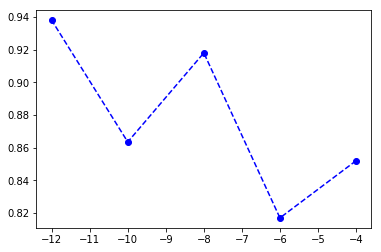

In [7]:
# seeing training on lower vs same snr

nn_accs = []

N = 27000 
SNRdB = -6
m = 300 

learning_rate = 0.005
num_iter = 8000
batch_size = 1000

test_signals, test_freqs = make_batch_singleton(batch_size, SNRdB, N, m)
test_signals_pair = np.zeros((batch_size, m, 2))
test_signals_pair[:, :, 0] = np.real(test_signals)
test_signals_pair[:, :, 1] = np.imag(test_signals)

snrs = [-4, -6, -8, -10, -12]

for snr in snrs:

    trial = []
    for _ in range(10):
        # Network Parameters
        num_classes = 3

        # tf Graph input
        X = tf.placeholder("float", [None, m, 2])
        Y = tf.placeholder("float", [None, num_classes])

        # Store layers weight & bias
        weights = {
            'h1': tf.Variable(tf.random_normal([5, 2, 2])), # filtersize, in channels, outchannels
            'out': tf.Variable(tf.random_normal([(m-4-2-2)*2, num_classes])),
            'h2': tf.Variable(tf.random_normal([3, 2, 2])),
            'h3': tf.Variable(tf.random_normal([3, 2, 2]))
        }
        biases = {
            'b1': tf.Variable(tf.random_normal([2])),
            'out': tf.Variable(tf.random_normal([num_classes])),
            'b2': tf.Variable(tf.random_normal([2])),
            'b3': tf.Variable(tf.random_normal([2]))
        }

        dict = {}
        training_size = 500
        for i in range(training_size):
            batch_x, batch_y = make_batch_singleton(batch_size, snr, N, m)
            batch_x_pair = np.zeros((batch_size, m, 2))
            batch_x_pair[:, :, 0] = np.real(batch_x)
            batch_x_pair[:, :, 1] = np.imag(batch_x)
            dict[i] = (batch_x_pair, batch_y)

        def neural_net(x):
            layer_1 = tf.add(tf.nn.conv1d(x, weights['h1'], 1, 'VALID'), biases['b1'])
            hidden_1 = tf.nn.relu(layer_1)
            layer_2 = tf.add(tf.nn.conv1d(hidden_1, weights['h2'], 1, 'VALID'), biases['b2'])
            hidden_2 = tf.nn.relu(layer_2)
            layer_3 = tf.add(tf.nn.conv1d(hidden_2, weights['h3'], 1, 'VALID'), biases['b3'])
            hidden_3 = tf.nn.relu(layer_3)
            hidden_3 = tf.reshape(hidden_3, [batch_size, -1])
            out_layer = tf.matmul(hidden_3, weights['out']) + biases['out']
            return out_layer

        # Construct model
        logits = neural_net(X)
        prediction = tf.nn.softmax(logits)
        losses, accuracies = [], []

        # Define loss and optimizer
        loss_op = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(
            logits=logits, labels=Y))  
        '''+ 0.01*tf.nn.l2_loss(weights['h1']) + 0.01*tf.nn.l2_loss(weights['h2']) + 0.01*tf.nn.l2_loss(weights['out']) \
        + 0.01*tf.nn.l2_loss(biases['b1']) + 0.01*tf.nn.l2_loss(biases['b2']) + 0.01*tf.nn.l2_loss(biases['out']) '''
        optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
        train_op = optimizer.minimize(loss_op)

        # Evaluate model
        correct_pred = tf.equal(tf.argmax(prediction, 1), tf.argmax(Y, 1))
        accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))

        # Initialize the variables (i.e. assign their default value)
        init = tf.global_variables_initializer()

        # Start training
        with tf.Session() as sess:

            # Run the initializer
            sess.run(init)

            for step in range(1, num_iter + 1):
                batch_x_pair, batch_y = dict[step % training_size]

                # Run optimization op (backprop)
                sess.run(train_op, feed_dict={X: batch_x_pair, Y: batch_y})
                if step % 500 == 0:
                    # Calculate batch loss and accuracy
                    loss, acc, pred = sess.run([loss_op, accuracy, prediction], feed_dict={X: batch_x_pair,
                                                                         Y: batch_y})

                    #print("pred: ", [np.argmax(a) for a in pred[:8]])
                    #print("act:", [np.argmax(a) for a in batch_y[:8]])
                    accuracies.append(acc)
                    losses.append(loss)
                    #print("snr: ", SNRdB)
                    #print("Iter " + str(step) + ", Minibatch Loss= " + \
                    #      "{:.4f}".format(loss) + ", Training Accuracy= " + \
                    #      "{:.3f}".format(acc))
            print("Training Finished for dataset snr=", snr)

            nn_acc = sess.run(accuracy, feed_dict={X: test_signals_pair, Y: test_freqs})        
            print("Testing Accuracy Neural:", nn_acc)
            trial.append(nn_acc)
    nn_accs.append(np.median(trial))
np.save('./data/singleton/snrs_training', snrs)
np.save('./data/singleton/nn_accs_snrs_training', nn_accs)
plt.plot(snrs, nn_accs, '--bo')
plt.show()

In [ ]:
#cnn binary

nn_accs = []
kay_accs = []

N = 512
SNRdB = 5
m = 32

# Parameters
learning_rate = 0.005
num_iter = 8000
batch_size = 500

# Network Parameters
num_classes = math.ceil(np.log2(N))

layers = [1, 3, 5, 7, 9, 11]

training_size = 1000
dict = {}
for i in range(training_size):
    batch_x, batch_y, _ = make_batch_noisy(batch_size, SNRdB, N, m, True)
    batch_x_pair = np.zeros((batch_size, m, 2))
    batch_x_pair[:, :, 0] = np.real(batch_x)
    batch_x_pair[:, :, 1] = np.imag(batch_x)
    dict[i] = (batch_x_pair, batch_y)
    
test_signals, test_freqs, test_freqs_onehot = make_batch_noisy(batch_size, SNRdB, N, m, True)
test_signals_pair = np.zeros((batch_size, m, 2))
test_signals_pair[:, :, 0] = np.real(test_signals)
test_signals_pair[:, :, 1] = np.imag(test_signals)


for layer in layers:

    trial = []
    for _ in range(10):

        # tf Graph input
        X = tf.placeholder("float", [None, m, 2])
        Y = tf.placeholder("float", [None, num_classes])

        # Store layers weight & bias



        # Store layers weight & bias
        weights = {i: tf.Variable(tf.random_normal([3, 2, 2])) for i in range(1, layer+1)}
        weights[0] = tf.Variable(tf.random_normal([5, 2, 2]))
        weights['out'] = tf.Variable(tf.random_normal([(m-4-(2*layer))*2, num_classes]))
        biases = {i: tf.Variable(tf.random_normal([2])) for i in range(layer+1)}
        biases['out'] = tf.Variable(tf.random_normal([num_classes]))


        def neural_net(x):
            layer_1 = tf.add(tf.nn.conv1d(x, weights[0], 1, 'VALID'), biases[0])
            hidden_1 = tf.nn.relu(layer_1)
            for i in range(1, layer+1):
                layer_1 = tf.add(tf.nn.conv1d(hidden_1, weights[i], 1, 'VALID'), biases[i])
                hidden_1 = tf.nn.relu(layer_1)
            hidden_3 = tf.reshape(hidden_1, [batch_size, -1])
            out_layer = tf.matmul(hidden_3, weights['out']) + biases['out']
            return out_layer


        # Construct model
        logits = neural_net(X)
        prediction = tf.round(tf.nn.sigmoid(logits))
        losses, accuracies = [], []

        # Define loss and optimizer
        loss_op = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(
            logits=logits, labels=Y))  
        ''' + 0.01*tf.nn.l2_loss(weights['h1']) + 0.01*tf.nn.l2_loss(weights['h2']) + 0.01*tf.nn.l2_loss(weights['out'])\
        + 0.01*tf.nn.l2_loss(biases['b1']) + 0.01*tf.nn.l2_loss(biases['b2']) + 0.01*tf.nn.l2_loss(biases['out'])'''
        optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
        train_op = optimizer.minimize(loss_op)


        correct_pred = tf.equal(prediction, Y)
        accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))

        # Initialize the variables (i.e. assign their default value)
        init = tf.global_variables_initializer()

        # Start training
        with tf.Session() as sess:

            # Run the initializer
            sess.run(init)

            for step in range(1, num_iter + 1):
                batch_x_pair, batch_y = dict[step % training_size]

                # Run optimization op (backprop)
                sess.run(train_op, feed_dict={X: batch_x_pair, Y: batch_y})
                if step % 100 == 0:
                    # Calculate batch loss and accuracy
                    loss, pred = sess.run([loss_op, prediction], feed_dict={X: batch_x_pair,
                                                                         Y: batch_y})
                    losses.append(loss)
                '''if step % 50000 == 0:
                    pred = sess.run(prediction, feed_dict={X: batch_x_pair,
                                                                         Y: batch_y})
                    preds = [binary_to_int(a).eval() for a in pred]
                    acts = [binary_to_int(a).eval() for a in batch_y]
                    print('batch accuracy: ', np.mean(np.equal(preds, acts)))
                    pred = sess.run(prediction, feed_dict={X: test_signals_pair, Y: test_freqs})
                    preds = [binary_to_int(a).eval() for a in pred]
                    acts = [binary_to_int(a).eval() for a in test_freqs]
                    print('test accuracy: ', np.mean(np.equal(preds, acts)))'''

            #print("Training Finished")

            loss, nn_acc, pred = sess.run([loss_op, accuracy, prediction], feed_dict={X: test_signals_pair, Y: test_freqs})
            #loss, nn_acc, pred = sess.run([loss_op, accuracy, prediction], feed_dict={X: full_sig_pair, Y: full_bin})
            #hammings = [hamming(a, b) for a, b in zip(pred, test_freqs)]
            #hamming_list.append(hammings)
            #print(np.mean(hammings))
            #plt.hist(hammings)
            #plt.show()
            preds = [binary_to_int(a).eval() for a in pred]
            acts = [binary_to_int(a).eval() for a in test_freqs] 
            nn_acc = np.mean(np.equal(preds, acts))

            #kay_acc = test_kays(test_signals, test_freqs, N)

            print("Testing Accuracy Neural:", nn_acc)

            #print("Testing Accuracy Kay:", kay_acc)
            trial.append(nn_acc)
            #kay_accs.append(kay_acc)
    nn_accs.append(np.median(trial))
np.save('./data/singleton/freq_layers', layers)
np.save('./data/singleton/freq_accs_layers', nn_accs)
plt.plot(layers, nn_accs, '--bo')
plt.show()

Testing Accuracy Neural: 0.036
Testing Accuracy Neural: 0.04
Testing Accuracy Neural: 0.06
